Loaded data from ./TestSys.csv


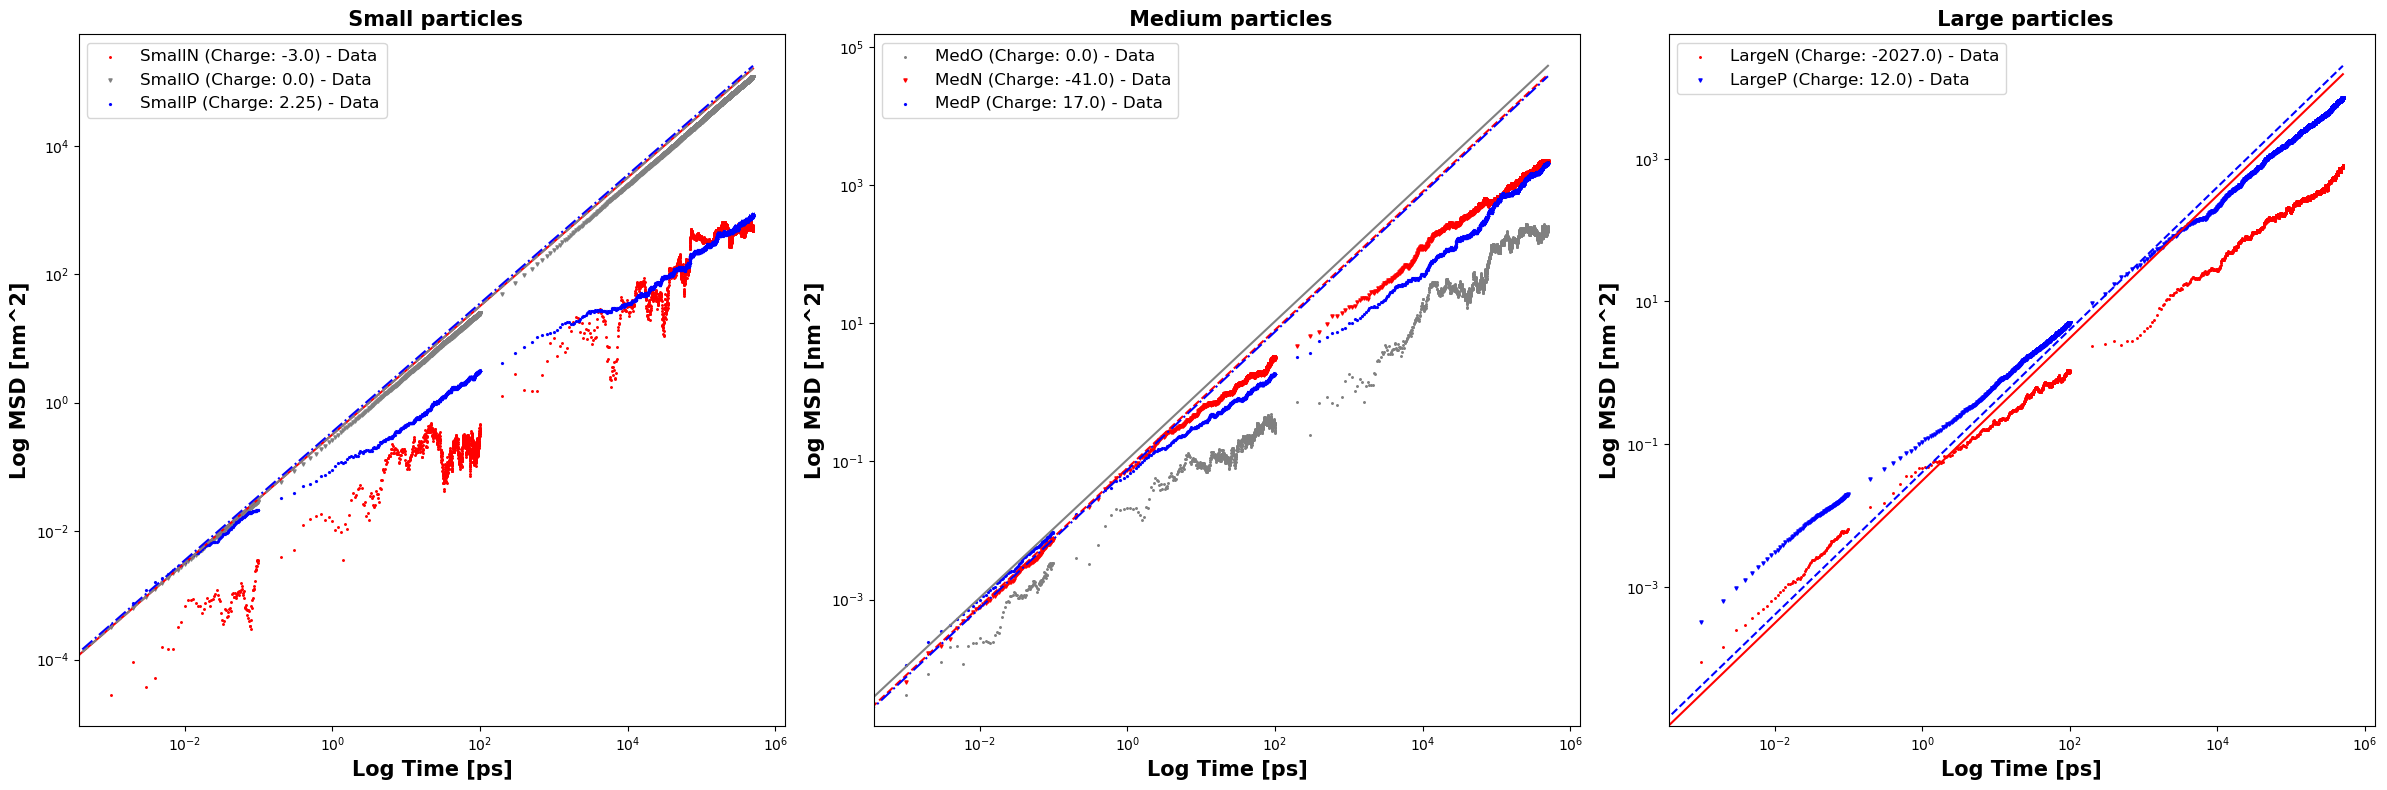

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import glob

# Increase the font size and bold the text for titles and axis labels globally
plt.rcParams.update({
    'axes.titlesize': 15,  # Increase the font size of the title
    'axes.titleweight': 'bold',  # Bold the title font
    'axes.labelsize': 15,  # Increase the font size of the axis labels
    'axes.labelweight': 'bold',  # Bold the axis label font
    'grid.alpha': 0.5,  # Set grid line transparency
    'legend.fontsize': 12  # Set the legend font size
})

# Constants
kT = float(1)        # Thermal energy
Viscosity = float(1)  # Viscosity of the medium

# Define the directory where the files are located
directory = './'

# Find all csv files in the specified directory that contain "Sys" and end with ".csv"
sys_csv_files = glob.glob(directory + '*Sys*.csv')

# Assuming you want to read the first file that matches the pattern
if sys_csv_files:  # Check if the list is not empty
    sys_data = pd.read_csv(sys_csv_files[0])
    print(f"Loaded data from {sys_csv_files[0]}")
else:
    print("No files found matching the pattern *Sys*.csv")

# Correcting the column name and reprocessing the data
sys_data = sys_data.rename(columns={' Radius': 'Radius'})

# Define thresholds for small, medium, and large categories
small_threshold = 1.0    # Example threshold, adjust as needed
medium_threshold = 5.0   # Example threshold, adjust as needed

# Function to categorize radius
def categorize_radius(radius):
    if radius <= small_threshold:
        return 'small'
    elif radius <= medium_threshold:
        return 'medium'
    else:
        return 'large'

# Group species by categorized radius
sys_data['Category'] = sys_data['Radius'].apply(categorize_radius)
grouped_species = sys_data.groupby('Category').apply(lambda x: list(x['Name'])).to_dict()

# Map species to charge and radius
species_charge = sys_data.set_index('Name')['Charge'].to_dict()
species_radius = sys_data.set_index('Name')['Radius'].to_dict()

# Define marker and linestyle for each species
marker_styles = ['.', 'v', '1', 'P', '*', 'X']  # Example marker styles
linestyle_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # Example line styles

def find_msd_files(species_name, directory='.'):
    """
    Finds MSD files for a given species in the specified directory.
    Files should be named in the format 'MSD_{SpeciesName}_trajectory_*.csv'.
    """
    pattern = f'MSD_{species_name}_trajectory_'
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith(pattern) and f.endswith('.csv')]

def plot_data(grouped_species, species_charge, species_radius, directory='.'):
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # Create 3 subplots side by side
    categories = ['small', 'medium', 'large']  # Ensure we plot in the order of increasing particle size

    for ax, category in zip(axs, categories):
        species_list = grouped_species.get(category, [])
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Assign a unique marker and linestyle to each species
        for i, species in enumerate(species_list):
            files = find_msd_files(species, directory)
            marker = marker_styles[i % len(marker_styles)]
            linestyle = linestyle_styles[i % len(linestyle_styles)]
            color = 'blue' if species_charge[species] > 0 else 'red' if species_charge[species] < 0 else 'gray'
            label_data = f'{species} (Charge: {species_charge[species]}) - Data'

            for file in files:
                data = pd.read_csv(file)
                time = data.iloc[:, 0]
                msd = data.iloc[:, 1]
                
                # Plotting data points
                ax.scatter(time, msd, label=label_data, color=color, marker=marker, s=5)

                # Calculate D_Exp for current species and plot trend line
                D_Exp = kT / (Viscosity * np.pi * species_radius[species])
                x_trend = time
                y_trend = D_Exp * x_trend
                ax.plot(x_trend, y_trend, color=color, linestyle=linestyle)

        ax.set_xlabel('Log Time [ps]')
        ax.set_ylabel('Log MSD [nm^2]')
        ax.set_title(f' {category.capitalize()} particles')
        ax.legend(loc='upper left')

    plt.tight_layout()
    plt.savefig('Combined_MSD.png', format='png')
    plt.show()

# Example usage
plot_data(grouped_species, species_charge, species_radius, directory)


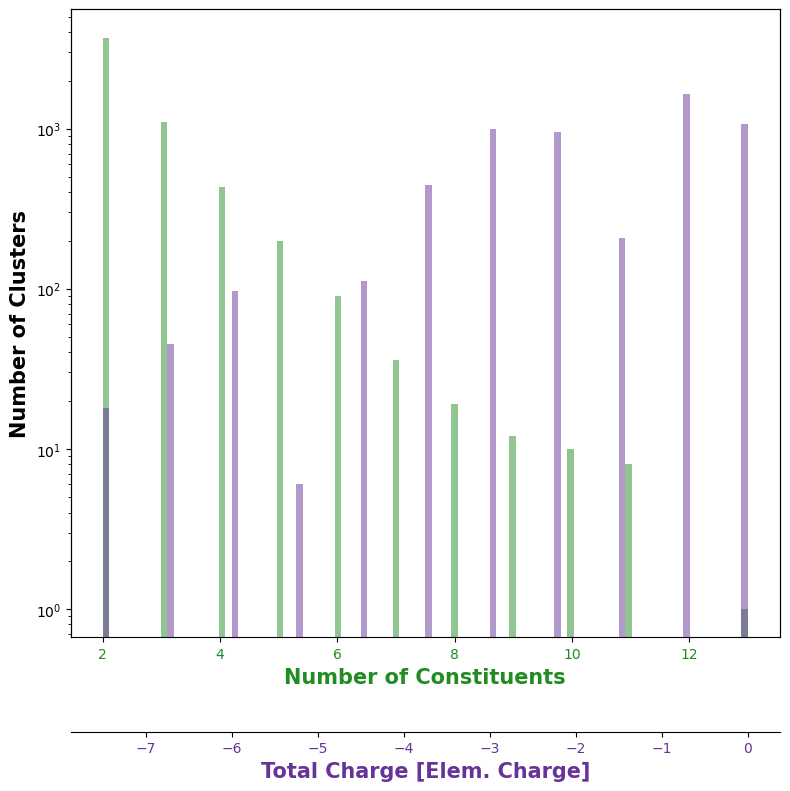

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm

# Increase the font size and bold the text for titles and axis labels globally
plt.rcParams.update({
    'axes.titlesize': 15,  # Increase the font size of the title
    'axes.titleweight': 'bold',  # Bold the title font
    'axes.labelsize': 15,  # Increase the font size of the axis labels
    'axes.labelweight': 'bold',  # Bold the axis label font
    'grid.alpha': 0.5,  # Set grid line transparency
    'legend.fontsize': 12  # Set the legend font size
})

Cluster_Statistics_file = './Cluster_Statistics.csv'

def plot_cluster_histograms_and_fits(file_path, fit_data=True):
    # Load the data
    cluster_data = pd.read_csv(file_path)
    
    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(8, 8))

    # Plot for Num_Constituents
    color_num_constituents = 'forestgreen'
    data_num_constituents = cluster_data['Num_Constituents']
    ax1.hist(data_num_constituents, bins=100, color=color_num_constituents, log=True, alpha=0.5)
    ax1.set_xlabel('Number of Constituents', color=color_num_constituents)
    ax1.set_ylabel('Number of Clusters', color='black')
    ax1.tick_params(axis='x', labelcolor=color_num_constituents)

    if fit_data:
        # Fit for Num_Constituents
        shape_num_constituents, loc_num_constituents, scale_num_constituents = lognorm.fit(data_num_constituents, floc=0)
        mu_num_constituents = np.log(scale_num_constituents)  # Convert scale parameter back to mu
        sigma_num_constituents = shape_num_constituents
        # Display equation for Num_Constituents fit on the top left
        equation_num_constituents = f'Log-Normal($\mu$={mu_num_constituents:.2f}, $\sigma$={sigma_num_constituents:.2f})'
        ax1.text(0.05, 0.95, equation_num_constituents, transform=ax1.transAxes, color=color_num_constituents, verticalalignment='top')

    # Plot for Total_Charge
    abs_charge = np.abs(cluster_data['Total_Charge'])
    ax2 = ax1.twiny()
    ax2.hist(-abs_charge, bins=100, color='rebeccapurple', log=True, alpha=0.5)
    ax2.tick_params(axis='x', labelcolor='rebeccapurple')
    ax2.xaxis.set_label_position('bottom')
    ax2.xaxis.tick_bottom()
    ax2.spines["bottom"].set_position(("axes", -0.15))
    ax2.set_xlabel('Total Charge [Elem. Charge]', color='rebeccapurple')

    if fit_data:
        # Fit for Total_Charge
        shape_charge, loc_charge, scale_charge = lognorm.fit(abs_charge, floc=0)
        mu_charge = np.log(scale_charge)  # Convert scale parameter back to mu
        sigma_charge = shape_charge
        # Display equation for Total_Charge fit on the top right
        equation_charge = f'Log-Normal($\mu$={mu_charge:.2f}, $\sigma$={sigma_charge:.2f})'
        ax2.text(0.95, 0.95, equation_charge, transform=ax2.transAxes, color='rebeccapurple', horizontalalignment='right', verticalalignment='top')

    fig.tight_layout()
    plt.savefig(f'Cluster_Histogram_Fits_Equations.png', format='png')
    plt.show()

# Example usage
plot_cluster_histograms_and_fits(Cluster_Statistics_file, fit_data=False)  # Set fit_data=False to plot without fitting


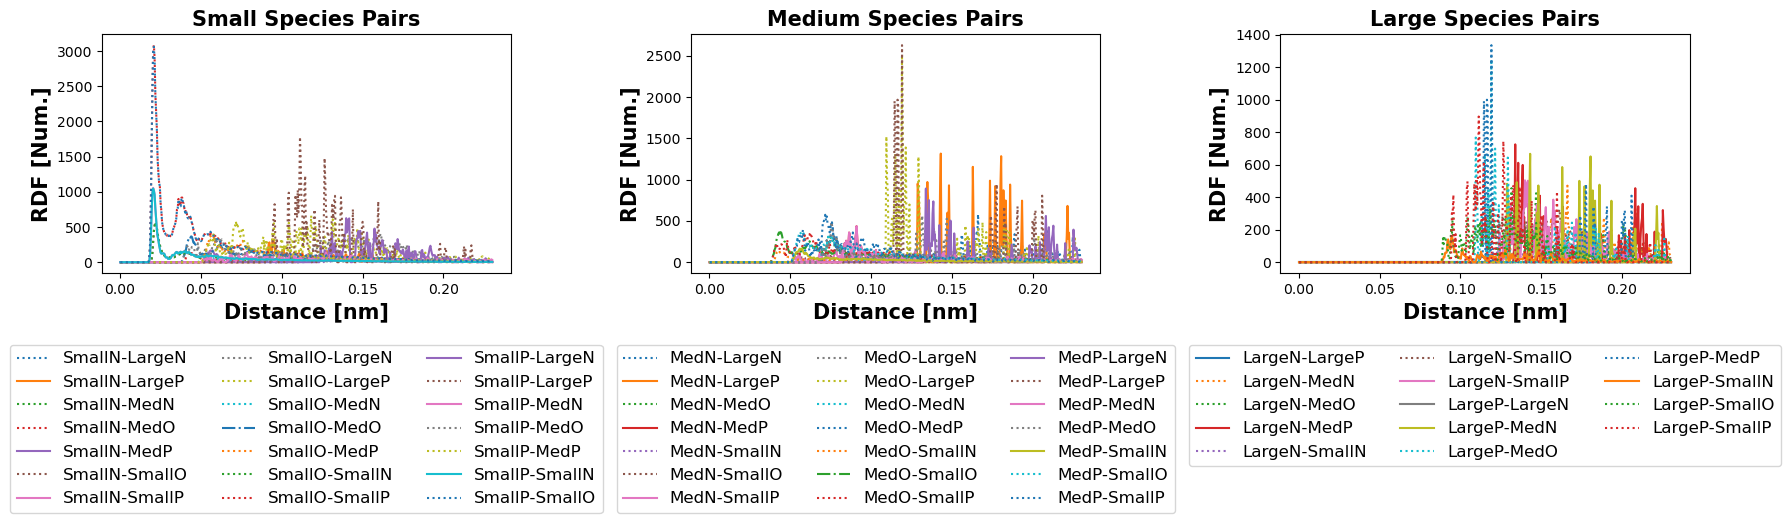

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

class TextHandler(HandlerBase):
    def create_artists(self, legend, text , xdescent, ydescent, width, height, fontsize, trans):
        tx = Text(width/2., height/2, text.get_text(), fontsize=fontsize, ha="center", va="center", rotation=90, color=text.get_color())
        return [tx]

# Increase the font size and bold the text for titles and axis labels globally
plt.rcParams.update({
    'axes.titlesize': 15,  # Increase the font size of the title
    'axes.titleweight': 'bold',  # Bold the title font
    'axes.labelsize': 15,  # Increase the font size of the axis labels
    'axes.labelweight': 'bold',  # Bold the axis label font
    'grid.alpha': 0.5,  # Set grid line transparency
    'legend.fontsize': 12  # Set the legend font size
})    
    
# Assuming system data and RDF data loading remains the same
# Load system data with species, charges, and radii
sys_csv_files = glob.glob('*Sys.csv')
if sys_csv_files:
    sys_data = pd.read_csv(sys_csv_files[0])
    sys_data = sys_data.rename(columns=lambda x: x.strip())  # Ensure correct column naming
    
    # Categorize species by size
    small_threshold, medium_threshold = 1.0, 5.0  # Adjust as needed
    sys_data['Size'] = sys_data['Radius'].apply(lambda x: 'small' if x <= small_threshold else ('medium' if x <= medium_threshold else 'large'))
    
    # Maps
    species_size = sys_data.set_index('Name')['Size'].to_dict()
    species_charge = sys_data.set_index('Name')['Charge'].to_dict()

# Load RDF data
rdf_data = pd.read_csv('./RDFs.csv')  # Adjust path as needed

# Define plotting settings
line_styles = {'same': 'dotted', 'neutral': '-.', 'opposite': 'solid'}
colors = ['red', 'blue', 'green']  # Example color cycle for differentiation

# Determine charge relationship
def charge_relationship(charge1, charge2):
    if charge1 == 0 and charge2 == 0:
        return 'neutral'
    elif (charge1 >= 0 and charge2 >= 0) or (charge1 <= 0 and charge2 <= 0):
        return 'same'
    else:
        return 'opposite'

# Adjusted plotting code with new requirements
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Removed sharey=True for independent y-axis scales
titles = ['small', 'medium', 'large']

# Define a cycle of colors for differentiation within subplots
color_cycle = plt.cm.tab10.colors  # Using one of Matplotlib's built-in colormaps

for col in rdf_data.columns[:-1]:  # Exclude the 'r' column
    _, i, j = col.split('_')
    if i != j:  # Exclude pairs where i=j
        size = species_size.get(i)
        if size:  # Ensure size is determined
            idx = titles.index(size)
            charge_rel = charge_relationship(species_charge[i], species_charge[j])
            # Get a color from the cycle based on the number of lines already plotted in this subplot
            color = color_cycle[len(axs[idx].get_lines()) % len(color_cycle)]
            axs[idx].plot(rdf_data['r'], rdf_data[col], linestyle=line_styles[charge_rel], color=color, label=f'{i}-{j}')
            axs[idx].set_title(f'{size.capitalize()} Species Pairs')
            axs[idx].set_xlabel('Distance [nm]')

# Adjusting legend and labels
for ax in axs:
    # Use custom handler for legend text rotation
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, handler_map={Text: TextHandler()}, bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=3, borderaxespad=0.)

    ax.set_ylabel('RDF [Num.]')

plt.tight_layout()
plt.savefig("Pairwise_RDFs_ij.png", bbox_inches='tight')
plt.show()


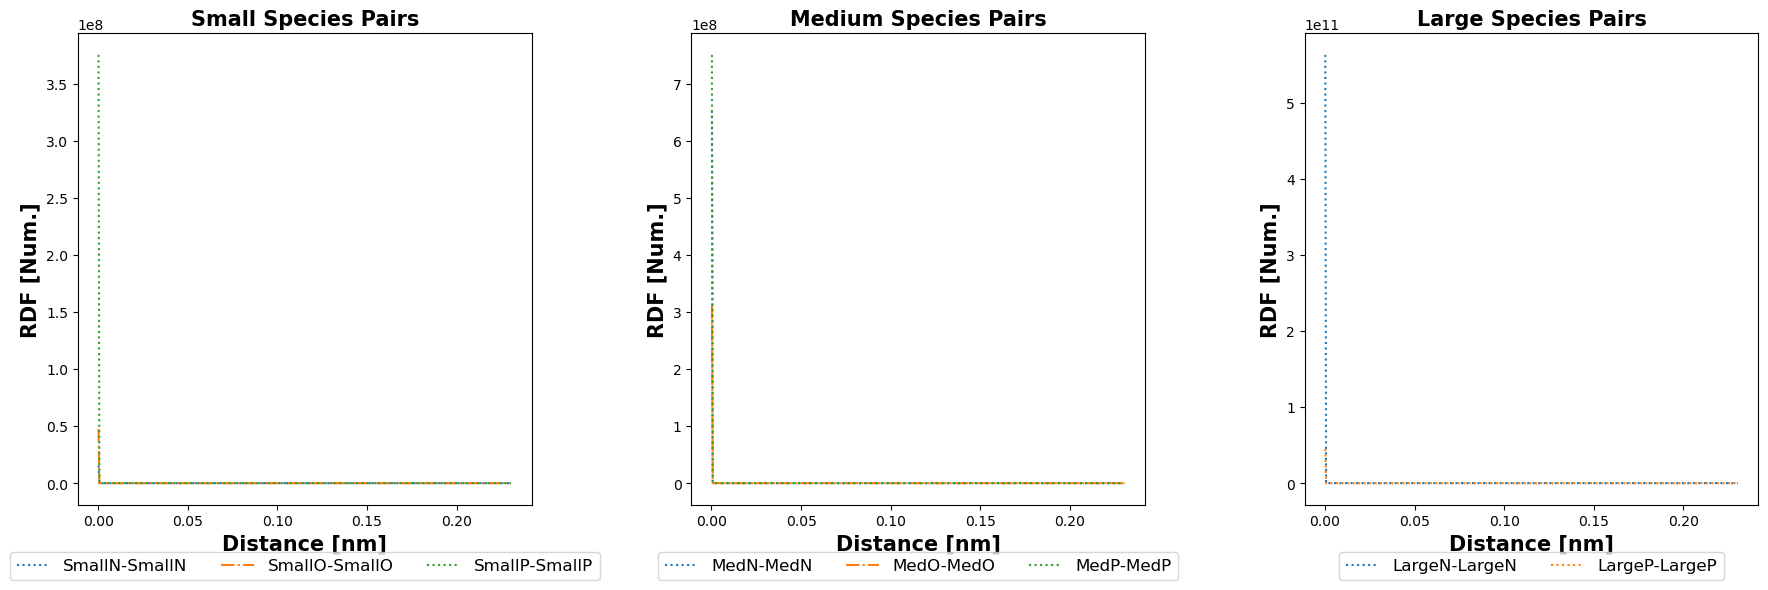

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

class TextHandler(HandlerBase):
    def create_artists(self, legend, text , xdescent, ydescent, width, height, fontsize, trans):
        tx = Text(width/2., height/2, text.get_text(), fontsize=fontsize, ha="center", va="center", rotation=90, color=text.get_color())
        return [tx]

# Increase the font size and bold the text for titles and axis labels globally
plt.rcParams.update({
    'axes.titlesize': 15,  # Increase the font size of the title
    'axes.titleweight': 'bold',  # Bold the title font
    'axes.labelsize': 15,  # Increase the font size of the axis labels
    'axes.labelweight': 'bold',  # Bold the axis label font
    'grid.alpha': 0.5,  # Set grid line transparency
    'legend.fontsize': 12  # Set the legend font size
})    
    
# Assuming system data and RDF data loading remains the same
# Load system data with species, charges, and radii
sys_csv_files = glob.glob('*Sys.csv')
if sys_csv_files:
    sys_data = pd.read_csv(sys_csv_files[0])
    sys_data = sys_data.rename(columns=lambda x: x.strip())  # Ensure correct column naming
    
    # Categorize species by size
    small_threshold, medium_threshold = 1.0, 5.0  # Adjust as needed
    sys_data['Size'] = sys_data['Radius'].apply(lambda x: 'small' if x <= small_threshold else ('medium' if x <= medium_threshold else 'large'))
    
    # Maps
    species_size = sys_data.set_index('Name')['Size'].to_dict()
    species_charge = sys_data.set_index('Name')['Charge'].to_dict()

# Load RDF data
rdf_data = pd.read_csv('./RDFs.csv')  # Adjust path as needed

# Define plotting settings
line_styles = {'same': 'dotted', 'neutral': '-.', 'opposite': 'solid'}
colors = ['red', 'blue', 'green']  # Example color cycle for differentiation

# Determine charge relationship
def charge_relationship(charge1, charge2):
    if charge1 == 0 and charge2 == 0:
        return 'neutral'
    elif (charge1 >= 0 and charge2 >= 0) or (charge1 <= 0 and charge2 <= 0):
        return 'same'
    else:
        return 'opposite'

# Adjusted plotting code with new requirements
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Removed sharey=True for independent y-axis scales
titles = ['small', 'medium', 'large']

# Define a cycle of colors for differentiation within subplots
color_cycle = plt.cm.tab10.colors  # Using one of Matplotlib's built-in colormaps

for col in rdf_data.columns[:-1]:  # Exclude the 'r' column
    _, i, j = col.split('_')
    if i == j:  # Exclude pairs where i=j
        size = species_size.get(i)
        if size:  # Ensure size is determined
            idx = titles.index(size)
            charge_rel = charge_relationship(species_charge[i], species_charge[j])
            # Get a color from the cycle based on the number of lines already plotted in this subplot
            color = color_cycle[len(axs[idx].get_lines()) % len(color_cycle)]
            axs[idx].plot(rdf_data['r'], rdf_data[col], linestyle=line_styles[charge_rel], color=color, label=f'{i}-{j}')
            axs[idx].set_title(f'{size.capitalize()} Species Pairs')
            axs[idx].set_xlabel('Distance [nm]')

# Adjusting legend and labels
for ax in axs:
    # Use custom handler for legend text rotation
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, handler_map={Text: TextHandler()}, bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, borderaxespad=0.)

    ax.set_ylabel('RDF [Num.]')

plt.tight_layout()
#plt.savefig("Pairwise_RDFs_ij.png", bbox_inches='tight')
plt.show()
